<a href="https://colab.research.google.com/github/KrishnaSChavan/MachineLearning/blob/main/DCGAN_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.keras import layers

In [2]:
(train_images, _), (_, _) = tf.keras. datasets.fashion_mnist.load_data()
train_images.shape

4422102/4422102 [==============================] - 1s 0us/step


(60000, 28, 28)

In [ ]:
da

In [3]:
train_images = train_images.reshape(train_images.shape [0], 28, 28, 1).astype('float32')
train_images.shape

(60000, 28, 28, 1)

In [4]:
train_images = (train_images-127.5)/ 127.5

In [5]:
buffer_size = 60000
Batch_size = 64

In [6]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(buffer_size).batch(Batch_size)

In [21]:
def generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256,input_shape = (100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.Reshape((7,7,256)))
    model.add(layers.Conv2DTranspose(128,(5,5),strides=(1,1),padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.Conv2DTranspose(64,(5,5),strides=(2,2),padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.Conv2DTranspose(1,(5,5),strides=(2,2),padding='same',activation='tanh'))

    return model

In [22]:
generator = generator_model()

generator.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 12544)             1266944   
                                                                 
 batch_normalization_4 (Batc  (None, 12544)            50176     
 hNormalization)                                                 
                                                                 
 re_lu_3 (ReLU)              (None, 12544)             0         
                                                                 
 reshape_2 (Reshape)         (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        819328    
 nspose)                                                         
                                                                 
 batch_normalization_5 (Batc  (None, 7, 7, 128)       

In [23]:
noise = tf.random.normal([1,100])
generated_image = generator(noise, training = False)
generated_image.shape

TensorShape([1, 28, 28, 1])

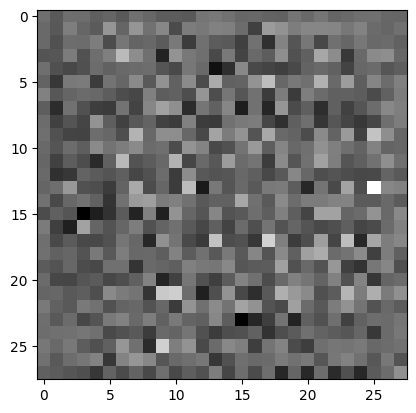

In [24]:
plt.imshow(generated_image[0,:, :, 0], cmap = 'gray')

In [31]:
def discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64,(5,5),strides=(2,2),padding='same',input_shape=[28,28,1]))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(64,(5,5),strides=(2,2),padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1,activation='sigmoid'))

    return model

In [34]:
discriminator = discriminator_model()

discriminator.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 14, 14, 64)        1664      
                                                                 
 batch_normalization_11 (Bat  (None, 14, 14, 64)       256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout_4 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 7, 7, 64)          102464    
                                                                 
 batch_normalization_12 (Bat  (None, 7, 7, 64)         256       
 chNormalization)                                     

In [35]:
output = discriminator (generated_image)
print (output)

tf.Tensor([[0.500224]], shape=(1, 1), dtype=float32)


In [51]:
be = tf.keras.losses.BinaryCrossentropy()

In [52]:
def descriminator_loss(real,fake):
    real_loss = be(tf.ones_like(real),real)
    fake_loss = be(tf.zeros_like(fake),fake)
    total_loss = real_loss + fake_loss

    return total_loss

In [53]:
def generator_loss(fake):
    gen_loss = be(tf.ones_like(fake),fake)
    return gen_loss

In [54]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001 ,beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001,beta_1 = 0.5 )

In [55]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path. join(checkpoint_dir, "ckpt")
checkpoint = tf. train.Checkpoint (generator_optimizer = generator_optimizer,
                                    discriminator_optimizer = discriminator_optimizer,
                                    generator = generator,
                                    discriminator = discriminator)

In [56]:
epochs = 50
noise_dim = 100
num_examples_to_generate = 16
seed = tf. random. normal ( [num_examples_to_generate, noise_dim])

In [57]:
def generate_and_plot_images (model, epoch, test_input):

    predictions = model (test_input, training = False)
    fig = plt.figure(figsize = (8, 4))
    for i in range (predictions.shape [0]):
        plt.subplot (4, 4, i+1)
        pred = (predictions[i, :, :, 0] + 1) * 127.5
        pred = np.array (pred)
        plt. imshow (pred.astype (np.uint8), cmap = 'gray')
        plt.axis ('off')
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show ( )

In [58]:
@tf.function
def train_step(images):
    noise = tf.random.normal([Batch_size,noise_dim])
    with tf.GradientTape() as gen_tape , tf.GradientTape() as disc_tape:
        generated_image = generator(noise,training=True)

        real_output = discriminator(images, training = True)
        fake_output = discriminator(generated_image, training = True)

        disc_loss = descriminator_loss (real_output, fake_output)
        gen_loss = generator_loss (fake_output )

    gradients_of_generator = gen_tape.gradient (gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient (disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables) )
    discriminator_optimizer.apply_gradients (zip(gradients_of_discriminator, discriminator.trainable_variables))

    return (gen_loss, disc_loss, tf. reduce_mean (real_output), tf. reduce_mean (fake_output))

In [59]:
def train(dataset,epochs):
    gen_loss_list = []
    disc_loss_list = []

    real_score_list =[]
    fake_score_list =[]

    for epoch in tqdm(range(epochs)):
        start = time.time ( )
        num_batches = len( dataset)

        print (f'Training started with epoch {epoch + 1} with {num_batches} batches...')

        total_gen_loss = 0
        total_disc_loss = 0
        for batch in dataset:
            generator_loss, discriminator_loss, real_score, fake_score = train_step (batch)
            total_gen_loss += generator_loss
            total_disc_loss += discriminator_loss

        mean_gen_loss = total_gen_loss / num_batches
        mean_disc_loss = total_disc_loss / num_batches

        print ('Losses after epoch %5d: generator %.3f, discriminator %.3f, real score %.2f%%, fake score %.2f%%' %
            (epoch + 1, generator_loss, discriminator_loss, real_score * 100, fake_score * 100))

        generate_and_plot_images (generator, epoch + 1, seed)

        gen_loss_list.append(mean_gen_loss)
        disc_loss_list.append(mean_disc_loss)
        real_score_list.append(real_score)
        fake_score_list.append( fake_score)

        if (epoch + 1) % 10 == 0:
            checkpoint.save (file_prefix = checkpoint_prefix)

    return gen_loss_list, disc_loss_list, real_score_list, fake_score_list

In [ ]:
gen_loss_epochs, disc_loss_epochs, real_score_list, fake_score_list = train(train_dataset, epochs = epochs)

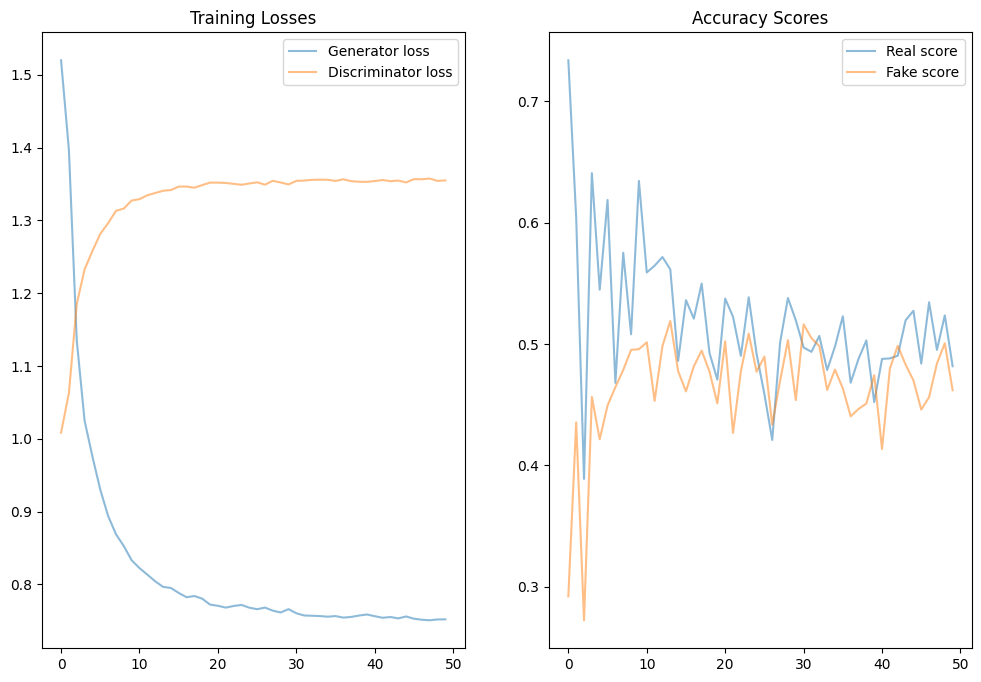

In [61]:
fig,(ax1, ax2) = plt.subplots (1, 2, figsize = (12, 8))
ax1.plot (gen_loss_epochs, label = 'Generator loss', alpha = 0.5)
ax1.plot (disc_loss_epochs, label = 'Discriminator loss', alpha = 0.5)
ax1. legend ()
ax1.set_title('Training Losses')
ax2.plot (real_score_list, label = 'Real score', alpha = 0.5)
ax2.plot(fake_score_list, label ="Fake score", alpha = 0.5)
ax2. set_title('Accuracy Scores')
ax2. legend()

In [65]:
from PIL import Image
z = Image.open('/content/image_at_epoch_0050.png',)

arr = np.asarray(z)

## Final generated images

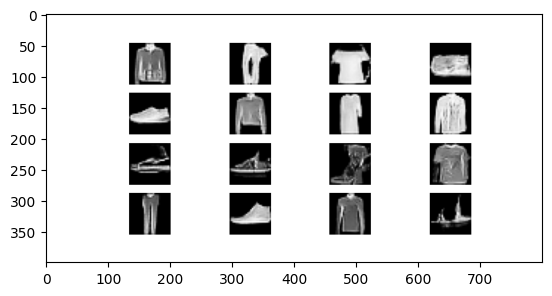

In [67]:
plt.imshow(arr)